In [1]:
import os
from glob import glob

import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceFocalLoss, DiceCELoss # type: ignore
from monai.inferers import sliding_window_inference # type: ignore
from monai import transforms # type: ignore
from monai.transforms import Compose, LoadImaged, ToTensord, EnsureChannelFirstd, Spacingd, CropForegroundd, Resized, Activations, AsDiscrete, ScaleIntensityRanged, SpatialCropd # type: ignore


from monai.config import print_config # type: ignore
from monai.metrics import DiceMetric # type: ignore
from monai.utils.enums import MetricReduction # type: ignore
from monai.networks.nets import UNet, BasicUNet # type: ignore
from monai import data
from monai.data import Dataset, DataLoader, decollate_batch
from functools import partial

import torch

#print_config()

c:\Users\Lenovo\anaconda3\envs\deeplearning\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
# Setup directory where checkpoints are stored

# Run from Lab's pc 
# checkpoint_dir = "C:\\Users\\manto\\OneDrive\\Desktop\Ilektra_Thesis_Code_Final\\Coronary-Arteries-Segmentation-with-BasicUNet\\LimitedData"
# Run from my laptop 
checkpoint_dir = "D:\\Coronary-Arteries-Segmentation-with-BasicUNet\\LimitedDataset_Experiment1"

# Average Meter is used to track the average of a metric over multiple iterations
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0            # Stores the latest value
        self.avg = 0            # Stores the running average
        self.sum = 0            # Sum of all values
        self.count = 0          # Number of updates

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n     # Accumulate sum
        self.count += n         # Increase count
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

# Function that saves a PyTorch model checkpoint (model's state, epoch number this was achieved, best accuracy so far)
def save_checkpoint(model, epoch, filename="best_model.pth", best_acc=0, dir_add=checkpoint_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [3]:
# Run from Lab's PC & my laptop
data_dir = "D:\\Electra\\data"

train_images = sorted(glob(os.path.join(data_dir, 'Cropped_TrainingData', '*.img.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'Cropped_TrainingData', '*.label.nii.gz')))

val_images = sorted(glob(os.path.join(data_dir, 'Cropped_ValidationData', '*.img.nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'Cropped_ValidationData', '*.label.nii.gz')))

# Choose limited images, 320 for training & 80 for validation.
train_images = train_images[:320]
train_labels = train_labels[:320]

val_images = val_images[:80]
val_labels = val_labels[:80]

# Create dictionaries with a path of each image and each label
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]

roi = (128, 128, 128)
# Due to inefficiency of GPU I reduced batch size to 1 from 2, and sw_batch_size to 2 from 4.
batch_size = 1
sw_batch_size = 2
infer_overlap = 0.5
max_epochs = 100
val_every = 5

train_transform = transforms.Compose(
    [
        transforms.LoadImageD(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.ScaleIntensityRanged(
            keys=["image"],
            a_min=-1024,
            a_max=1500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.38, 0.38, 0.5),  
            mode=("bilinear", "nearest")
        ),
        #transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Resized(keys=["image", "label"], spatial_size=(roi[0], roi[1], roi[2]), mode=['area', 'nearest']),
        transforms.ToTensorD(keys=["image", "label"]),
    ]
)          

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.ScaleIntensityRanged(
            keys=["image"],
            a_min=-1024,
            a_max=1500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.38, 0.38, 0.5),  
            mode=("bilinear", "nearest")
        ),
        #transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Resized(keys=["image", "label"], spatial_size=(roi[0], roi[1], roi[2]), mode=['area', 'nearest']),
        transforms.ToTensorD(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_files, transform=train_transform)

train_loader = data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
    
val_ds = data.Dataset(data=val_files, transform=val_transform)
    
val_loader = data.DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

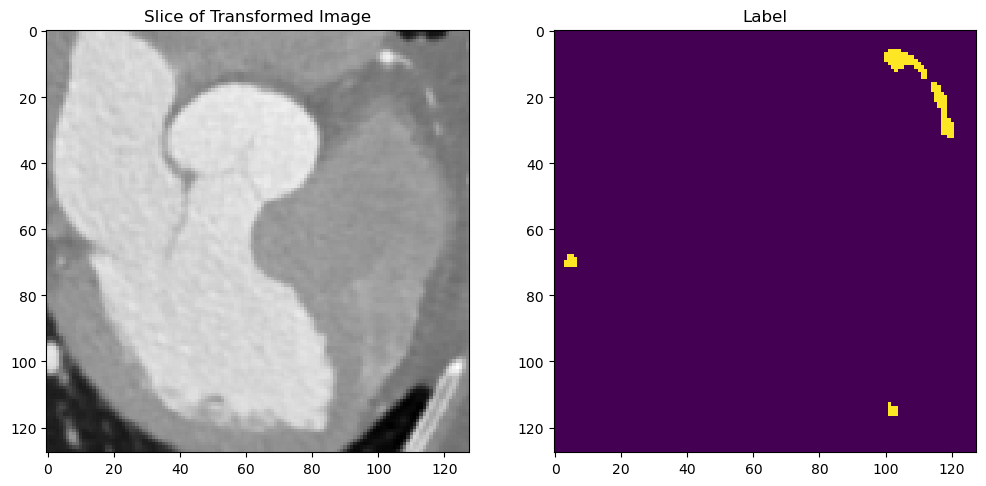

In [11]:
import torch
import matplotlib.pyplot as plt

# Get a single batch from the train_loader (faster than first())
batch = next(iter(train_loader))  # Only takes the first batch instead of the whole dataset

# Extract the first sample from the batch
image = batch["image"][0, 0, :, :, 64]  # Middle slice in the z-direction
label = batch["label"][0, 0, :, :, 64]

# Plot the image and its corresponding label
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Slice of Transformed Image")
plt.imshow(image.numpy(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label.numpy())

plt.show()

In [12]:
from monai.transforms import SaveImaged
import os
import nibabel as nib

# Output directory (if not already defined)
output_dir = "D:\\Electra\\data\\transformed_images"
os.makedirs(output_dir, exist_ok=True)

def save_transformed_sample(index=0):
    sample = train_ds[index]

    # Extract original image path and name
    image_meta_path = sample["image"].meta["filename_or_obj"]
    image_name = os.path.basename(image_meta_path)
    print(f"Original image filename: {image_name}")

    # Show original affine from the source NIfTI
    original_nib = nib.load(image_meta_path)
    print("Original affine (from source NIfTI):")
    print(original_nib.affine)

    # Show MONAI metadata affines
    print("Transformed image .meta['affine']:", sample["image"].meta.get("affine", "Not available"))
    print("Transformed image .affine (if exists):", getattr(sample["image"], "affine", "No .affine"))

    # make label affine match image affine
    sample["label"].affine = sample["image"].affine

    # Save using SaveImaged
    saver = SaveImaged(
        keys=["image", "label"],
        output_dir=output_dir,
        output_postfix="transformed",
        separate_folder=False,
        resample=False,  # Keep original spacing/orientation
        print_log=True
    )

    saver({"image": sample["image"], "label": sample["label"]})

# Change index to run 
save_transformed_sample(280)

Original image filename: cropped_350.img.nii.gz
Original affine (from source NIfTI):
[[  -0.3828125    -0.            0.           31.26953125]
 [  -0.            0.3828125    -0.          138.33984375]
 [   0.            0.            0.5        -253.54998779]
 [   0.            0.            0.            1.        ]]
Transformed image .meta['affine']: tensor([[  -0.9233,    0.0000,    0.0000,   30.9979],
        [   0.0000,    0.7511,    0.0000,  138.5254],
        [   0.0000,    0.0000,    0.7734, -253.4133],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
Transformed image .affine (if exists): tensor([[  -0.9233,    0.0000,    0.0000,   30.9979],
        [   0.0000,    0.7511,    0.0000,  138.5254],
        [   0.0000,    0.0000,    0.7734, -253.4133],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
2025-04-16 17:41:36,677 INFO image_writer.py:197 - writing: D:\Electra\data\transformed_images\cropped_350.img_transformed.nii.g

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
torch.cuda.empty_cache()

# Initialize the BasicUNet model
model = BasicUNet(
    spatial_dims=3,                                               # For 3D segmentation
    in_channels=1,                                                # Grayscale input images
    out_channels=2,                                               # 2 output classes: background and coronary arteries
    features=(32, 32, 64, 128, 256, 32),                          # Feature sizes
    act=('LeakyReLU', {'inplace': True, 'negative_slope': 0.1}),  # Activation function
    norm=('instance', {'affine': True}),                          # Normalization
    dropout=0.1,                                                  # Optional dropout for regularization
    upsample='deconv'                                             # Use deconvolution for upsampling
).to(device)

True
BasicUNet features: (32, 32, 64, 128, 256, 32).


In [5]:
torch.backends.cudnn.benchmark = True

dice_loss = DiceCELoss(include_background=True, to_onehot_y=True, sigmoid=True)
dice_acc  = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)

post_sigmoid = Activations(sigmoid=True)
post_pred    = AsDiscrete(argmax=False, threshold=0.5)

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [6]:
def train_epoch(model, loader, optimizer, epoch, loss_func, device, max_epochs, batch_size):
    model.train()  # Set model to training mode
    run_loss = AverageMeter()
    start_time = time.time()

    for idx, batch_data in enumerate(loader):
        # Move data to the appropriate device
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(data)
        
        # Compute loss
        loss = loss_func(logits, target)
        
        # Backward pass
        loss.backward()
        
        # Optional: Clip gradients (useful for stability in large models)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        optimizer.zero_grad()  # Clear the gradients after each step

        
        # Update loss tracking
        run_loss.update(loss.item(), n=data.size(0))  # Use actual batch size
        
        # Log information periodically
        if idx % (len(loader) // 10 or 1) == 0:  # Log every 10% of an epoch
            elapsed = time.time() - start_time
            print(
                f"Epoch {epoch}/{max_epochs} Batch {idx}/{len(loader)} "
                f"Loss: {run_loss.avg:.4f} Time: {elapsed:.2f}s"
            )
            start_time = time.time()  # Reset start time for next log

    return run_loss.avg

def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    device,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()  # Set model to evaluation mode
    run_acc = AverageMeter()
    start_time = time.time()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            # Move data to the appropriate device
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            
            # Model inference
            logits = model_inferer(data) if model_inferer else model(data)
            
            # Post-processing
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            
            # Compute metrics
            acc_func.reset()  # Reset metric accumulator
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            
            # Log batch metrics periodically
            if idx % (len(loader) // 10 or 1) == 0:  # Log every 10% of the epoch
                dice_tc = run_acc.avg[0]  # First metric (e.g., binary Dice score)
                elapsed = time.time() - start_time
                print(
                    f"Validation {epoch}/{max_epochs} Batch {idx}/{len(loader)} "
                    f"Dice_TC: {dice_tc:.4f} Time: {elapsed:.2f}s"
                )
                start_time = time.time()  # Reset timer

    return run_acc.avg

In [7]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler=None,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
    max_epochs=max_epochs,  # Maximum number of epochs
    val_every=val_every,  # Frequency for validation
    device="cuda",  # Specify the device
    save_path="best_model.pth",  # Path to save the best model
):
    val_acc_max = 0.0  # Track the best validation accuracy (Dice score)
    dices_avg = []  # Store average Dice scores across epochs
    loss_epochs = []  # Store training loss per epoch
    trains_epoch = []  # Store epoch numbers

    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), f"Epoch {epoch}/{max_epochs - 1}")
        epoch_start_time = time.time()

        # Training step
        train_loss = train_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            loss_func=loss_func,
            device=device,  # Pass the device
            max_epochs=max_epochs,  # Pass max_epochs for logging
            batch_size=train_loader.batch_size,  # Retrieve batch size from loader
        )

        print(
            f"Training {epoch}/{max_epochs - 1} - Loss: {train_loss:.4f} - "
            f"Time: {time.time() - epoch_start_time:.2f}s"
        )

        loss_epochs.append(train_loss)  # Store training loss for the epoch
        trains_epoch.append(epoch)  # Store the epoch number

        # Validate every 'val_every' epochs or at the first epoch
        if (epoch + 1) % val_every == 0 or epoch == 0:
            val_start_time = time.time()

            # Validation step
            val_acc = val_epoch(
                model=model,
                loader=val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
                device=device,  # Pass the device
            )

            # Compute the average Dice score
            val_avg_acc = np.mean(val_acc)
            dices_avg.append(val_avg_acc)  # Store validation accuracy for the epoch

            print(
                f"Validation {epoch}/{max_epochs - 1} - Avg Dice: {val_avg_acc:.4f} - "
                f"Time: {time.time() - val_start_time:.2f}s"
            )

            # Check for the best validation accuracy
            if val_avg_acc > val_acc_max:
                print(f"New Best Accuracy: {val_acc_max:.4f} --> {val_avg_acc:.4f}")
                val_acc_max = val_avg_acc  # Update best validation accuracy

                # Save the best model checkpoint
                torch.save(model.state_dict(), save_path)
                print(f"Saved Best Model to {save_path}")

        # Update the learning rate scheduler
        if scheduler:
            scheduler.step()

    # Training finished, print final stats
    print(f"Training Complete! Best Validation Dice Score: {val_acc_max:.4f}")

    return val_acc_max, dices_avg, loss_epochs, trains_epoch

In [12]:
start_epoch = 0  

# Run the trainer function
val_acc_max, dices_avg, loss_epochs, trains_epoch = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,  # Dice loss for binary segmentation
    acc_func=dice_acc,  # Dice accuracy for performance evaluation
    scheduler=scheduler,  # Learning rate scheduler
    model_inferer=model_inferer,  # Optional: handles inference steps (e.g., softmax/sigmoid)
    start_epoch=start_epoch,  # Starting epoch (useful for resuming training)
    post_sigmoid=post_sigmoid,  # Apply sigmoid for probability conversion
    post_pred=post_pred,  # Thresholding function to get binary predictions
    max_epochs=max_epochs,  # Total number of epochs for training
    val_every=val_every,  # Perform validation every 10 epochs
    device="cuda" if torch.cuda.is_available() else "cpu",  # Device selection
    save_path="best_model.pth",  # Path to save the best model
)

Wed Apr  9 13:13:04 2025 Epoch 0/99
Epoch 0/100 Batch 0/320 Loss: 1.3662 Time: 31.25s
Epoch 0/100 Batch 32/320 Loss: 1.1320 Time: 51.82s
Epoch 0/100 Batch 64/320 Loss: 1.0469 Time: 52.80s
Epoch 0/100 Batch 96/320 Loss: 0.9948 Time: 52.20s
Epoch 0/100 Batch 128/320 Loss: 0.9560 Time: 52.37s
Epoch 0/100 Batch 160/320 Loss: 0.9246 Time: 53.63s
Epoch 0/100 Batch 192/320 Loss: 0.8982 Time: 52.58s
Epoch 0/100 Batch 224/320 Loss: 0.8752 Time: 51.82s
Epoch 0/100 Batch 256/320 Loss: 0.8551 Time: 52.20s
Epoch 0/100 Batch 288/320 Loss: 0.8368 Time: 52.42s
Training 0/99 - Loss: 0.8207 - Time: 548.23s
Validation 0/100 Batch 0/80 Dice_TC: 0.7262 Time: 14.33s
Validation 0/100 Batch 8/80 Dice_TC: 0.7681 Time: 2.14s
Validation 0/100 Batch 16/80 Dice_TC: 0.7633 Time: 1.78s
Validation 0/100 Batch 24/80 Dice_TC: 0.7616 Time: 2.23s
Validation 0/100 Batch 32/80 Dice_TC: 0.7633 Time: 2.31s
Validation 0/100 Batch 40/80 Dice_TC: 0.7657 Time: 1.83s
Validation 0/100 Batch 48/80 Dice_TC: 0.7636 Time: 2.85s
Valida

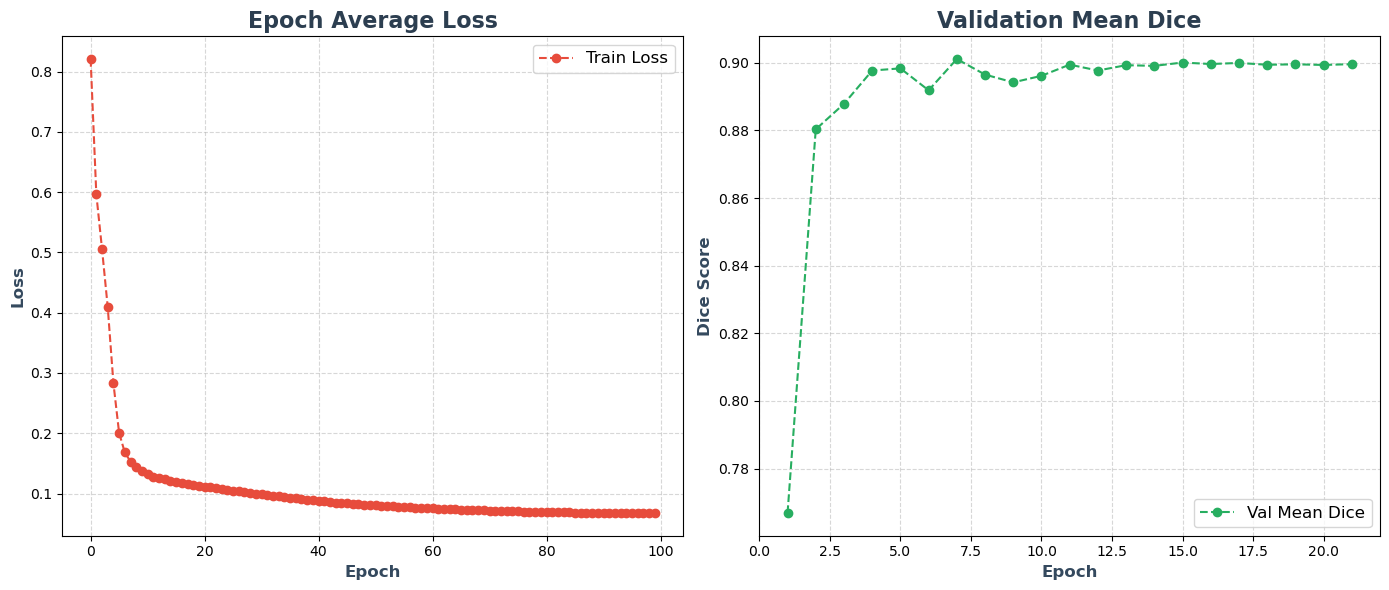

In [13]:
# Ensure trains_epoch and loss_epochs match
assert len(trains_epoch) == len(loss_epochs), "Mismatch between epochs and loss values"

# Generate x-axis values for validation Dice
epochs = list(range(1, len(dices_avg) + 1))

# Create figure with a wider layout
plt.figure("Training and Validation Metrics", figsize=(14, 6), dpi=100)

# --- Subplot 1: Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(trains_epoch, loss_epochs, color="#E74C3C", linestyle="--", marker="o", markersize=6, label="Train Loss")
plt.title("Epoch Average Loss", fontsize=16, fontweight="bold", color="#2C3E50")
plt.xlabel("Epoch", fontsize=12, fontweight="bold", color="#34495E")
plt.ylabel("Loss", fontsize=12, fontweight="bold", color="#34495E")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, loc="upper right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# --- Subplot 2: Validation Mean Dice ---
plt.subplot(1, 2, 2)
plt.plot(epochs, dices_avg, color="#27AE60", linestyle="--", marker="o", markersize=6, label="Val Mean Dice")
plt.title("Validation Mean Dice", fontsize=16, fontweight="bold", color="#2C3E50")
plt.xlabel("Epoch", fontsize=12, fontweight="bold", color="#34495E")
plt.ylabel("Dice Score", fontsize=12, fontweight="bold", color="#34495E")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, loc="lower right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout and show the final result
plt.tight_layout()
plt.show()

In [8]:
# Run from Lab's PC.
#model_path = "C:\\Users\\manto\OneDrive\\Desktop\\Ilektra_Thesis_Code_Final\\Coronary-Arteries-Segmentation-with-BasicUNet\\LimitedData"

# Run from my laptop
model_path = "D:\\Coronary-Arteries-Segmentation-with-BasicUNet\\LimitedDataset_Experiment1"

model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth")))
model.to(device)
model.eval()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9852\3596502646.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "b

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.1, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.1, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
 

In [9]:
# Post-processing transforms for prediction
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)

In [ ]:
import os
import glob

# Choose limited test images
test_images = sorted(glob.glob(os.path.join(data_dir, 'Cropped_TestData', '*.img.nii.gz')))[:100]
test_labels = sorted(glob.glob(os.path.join(data_dir, 'Cropped_TestData', '*.label.nii.gz')))[:100]

# Create dictionaries with a path of each image and each label just like train and validation
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]


# Define appropriate transforms for your task
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.ScaleIntensityRanged(
            keys=["image"],
            a_min=-1024,
            a_max=1500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        transforms.Spacingd(
            keys=["image", "label"],
            pixdim=(0.38, 0.38, 0.5), 
            mode=("bilinear", "nearest")
        ),
        transforms.Resized(keys=["image", "label"], spatial_size=(roi[0], roi[1], roi[2]), mode=['area', 'nearest']),
        transforms.ToTensorD(keys=["image", "label"]),
    ]
)

# Create dataset and loader
test_ds = data.Dataset(data=test_files, transform=test_transform)
test_loader = data.DataLoader(
    test_ds,
    batch_size=1,  # Adjust based on GPU capacity
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

# Post-processing functions for binary segmentation
post_sigmoid = torch.sigmoid
# Thresholding at 0.5 for binary
post_pred = lambda x: (x > 0.5).float()  

Processing image: cropped_839.img.nii.gz


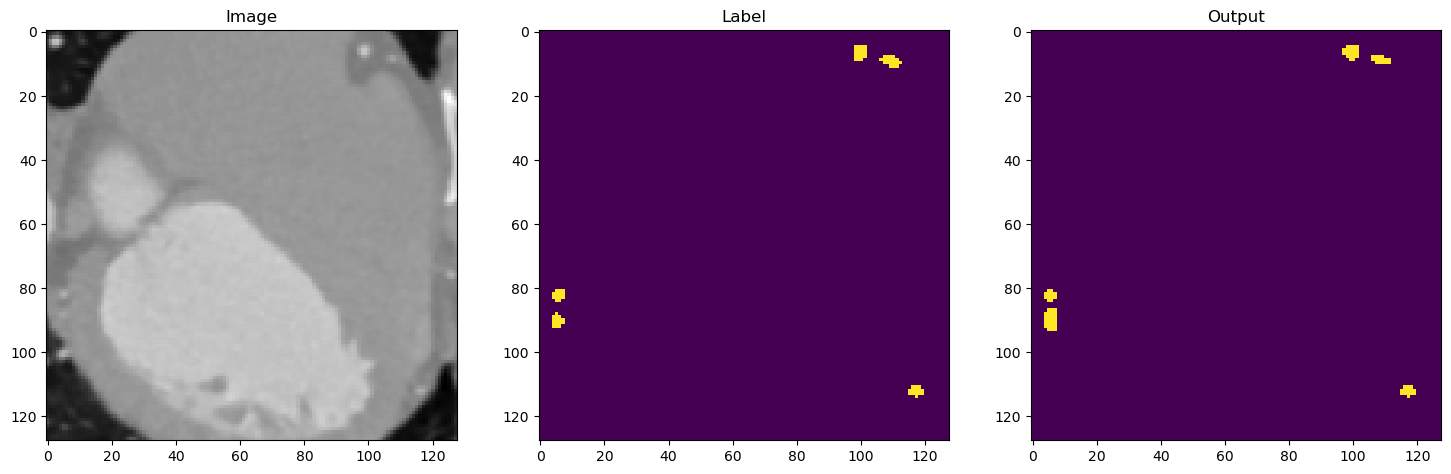

Saved image to: D:\Electra\data\Results\BasicUNet\Limited\LPI_Oriented\testimage_case_21.nii.gz
Saved label to: D:\Electra\data\Results\BasicUNet\Limited\LPI_Oriented\testlabel_case_21.nii.gz
Saved output to: D:\Electra\data\Results\BasicUNet\Limited\LPI_Oriented\testoutput_case_21.nii.gz


In [25]:
import os
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
import numpy as np

# Saves them in LPI transform while original images are RPI. 
# Kept only for comparisons. This is why I needed to change the approach. 

# Slice map for specific slices
slice_map = {
    "cropped_901.img.nii.gz": 80,
    "cropped_902.img.nii.gz": 81,
    "cropped_903.img.nii.gz": 82,
    "cropped_904.img.nii.gz": 83,
    "cropped_905.img.nii.gz": 84,
    "cropped_906.img.nii.gz": 85,
}

# Specify the case number and the output directory
case_num = 21
output_dir = "D:\\Electra\\data\\Results\\BasicUNet\\Limited\\LPI_Oriented"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    # Load image and label from test dataset
    img = test_ds[case_num]["image"]
    label = test_ds[case_num]["label"]

    # Get the original filename from metadata
    img_name = os.path.basename(img.meta["filename_or_obj"])
    print(f"Processing image: {img_name}")

    # Add batch and channel dimensions, move to GPU
    test_inputs = torch.unsqueeze(img, 1).cuda()
    test_labels = torch.unsqueeze(label, 1).cuda()

    # Perform inference
    test_outputs = sliding_window_inference(test_inputs, (128, 128, 128), 4, model, overlap=0.5)

    # Choose slice to visualize
    slice_idx = slice_map.get(img_name, test_inputs.shape[-1] // 2)

    # Visualize image, label, and prediction
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Label")
    plt.imshow(test_labels.cpu().numpy()[0, 0, :, :, slice_idx])

    plt.subplot(1, 3, 3)
    plt.title("Output")
    plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, slice_idx])

    plt.show()

    # Define output file paths
    img_save_path = os.path.join(output_dir, f"testimage_case_{case_num}.nii.gz")
    label_save_path = os.path.join(output_dir, f"testlabel_case_{case_num}.nii.gz")
    output_save_path = os.path.join(output_dir, f"testoutput_case_{case_num}.nii.gz")

    # Save image, label, and prediction as NIfTI
    nib.save(nib.Nifti1Image(test_inputs.cpu().numpy()[0, 0], affine=np.eye(4)), img_save_path)
    nib.save(nib.Nifti1Image(test_labels.cpu().numpy()[0, 0], affine=np.eye(4)), label_save_path)

    prediction = torch.argmax(test_outputs, dim=1).detach().cpu().numpy()[0].astype(np.int32)
    nib.save(nib.Nifti1Image(prediction, affine=np.eye(4)), output_save_path)

    print(f"Saved image to: {img_save_path}")
    print(f"Saved label to: {label_save_path}")
    print(f"Saved output to: {output_save_path}")

In [37]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from monai.transforms import SaveImaged

# Output directory
output_dir = "D:\\Electra\\data\\Results\\BasicUNet\\Limited"
os.makedirs(output_dir, exist_ok=True)

# Choose test case index, use 51 to compare
case_index = 3
model.eval()

with torch.no_grad():
    sample = test_ds[case_index]
    image = sample["image"]
    label = sample["label"]
    image_name = os.path.basename(image.meta["filename_or_obj"])
    print(f"Processing image: {image_name}")

    # Add batch + channel and move to GPU
    test_input = torch.unsqueeze(image, 1).cuda()

    # Predict
    raw_pred = sliding_window_inference(test_input, (128, 128, 128), 4, model, overlap=0.5)
    print("Prediction shape:", raw_pred.shape)

    # Use argmax to get predicted class
    pred_class = torch.argmax(raw_pred, dim=1)  # shape: [1, H, W, D]

    # Extract only class 1 (artery mask), convert to binary mask
    artery_mask = (pred_class == 1).to(torch.uint8)

    # Remove batch dimension
    artery_mask = artery_mask[0]

    # Attach metadata and affine for correct alignment
    artery_mask.meta = image.meta
    artery_mask.affine = image.affine
    label.affine = image.affine

    # Save everythinh
    saver_img  = SaveImaged(keys="image", output_dir=output_dir, output_postfix="test_basicunet_limited", separate_folder=False, resample=False, print_log=True)
    saver_lbl  = SaveImaged(keys="label", output_dir=output_dir, output_postfix="test_basicunet_limited", separate_folder=False, resample=False, print_log=True)
    saver_pred = SaveImaged(keys="prediction", output_dir=output_dir, output_postfix="prediction_basicunet_limited", separate_folder=False, resample=False, print_log=True)

    saver_img({"image": image})
    saver_lbl({"label": label})
    saver_pred({"prediction": artery_mask})

Processing image: cropped_822.img.nii.gz
Prediction shape: torch.Size([1, 2, 128, 128, 128])
2025-05-02 16:42:49,170 INFO image_writer.py:197 - writing: D:\Electra\data\Results\BasicUNet\Limited\cropped_822.img_test_basicunet_limited.nii.gz
2025-05-02 16:42:49,710 INFO image_writer.py:197 - writing: D:\Electra\data\Results\BasicUNet\Limited\cropped_822.label_test_basicunet_limited.nii.gz
2025-05-02 16:42:49,784 INFO image_writer.py:197 - writing: D:\Electra\data\Results\BasicUNet\Limited\cropped_822.img_prediction_basicunet_limited.nii.gz


In [26]:
import torch
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.data import DataLoader, decollate_batch

# DiceMetric includes background class and computes mean across batch
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)

# Separate post-processing for outputs and labels
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])  
post_label = Compose([AsDiscrete(to_onehot=2)])              

# Set model to evaluation mode
model.eval()

# Create test DataLoader
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(images)

        # Decollate and apply post-processing
        outputs = [post_pred(i.cpu()) for i in decollate_batch(outputs)]
        labels = [post_label(i.cpu()) for i in decollate_batch(labels)]

        # Compute Dice
        dice_metric(y_pred=outputs, y=labels)

# Aggregate Dice and reset metric
mean_dice, _ = dice_metric.aggregate()
dice_metric.reset()

print(f"Test Dice Score (with background): {mean_dice.item():.4f}")

Test Dice Score (with background): 0.8994


In [27]:
import torch
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.data import DataLoader, decollate_batch

# DiceMetric for single-sample evaluation (mean over classes)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)

# Post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])  
post_label = Compose([AsDiscrete(to_onehot=2)])              

# Model to eval mode
model.eval()

# Test DataLoader
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# Store per-sample Dice scores
sample_dice_scores = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(images)

        # Decollate and post-process
        outputs = [post_pred(o.cpu()) for o in decollate_batch(outputs)]
        labels = [post_label(l.cpu()) for l in decollate_batch(labels)]

        # Compute Dice
        dice_metric(y_pred=outputs, y=labels)
        sample_dice, _ = dice_metric.aggregate()
        dice_metric.reset()

        # Store and print
        score = sample_dice.item()
        sample_dice_scores.append(score)
        print(f"Sample {i:03d} Dice Score: {score:.4f}")

# Compute final average
final_avg_dice = sum(sample_dice_scores) / len(sample_dice_scores)
print(f"\nFinal Average Dice Score: {final_avg_dice:.4f}")


Sample 000 Dice Score: 0.9158
Sample 001 Dice Score: 0.9137
Sample 002 Dice Score: 0.9185
Sample 003 Dice Score: 0.9230
Sample 004 Dice Score: 0.9096
Sample 005 Dice Score: 0.9140
Sample 006 Dice Score: 0.9305
Sample 007 Dice Score: 0.8984
Sample 008 Dice Score: 0.8927
Sample 009 Dice Score: 0.8986
Sample 010 Dice Score: 0.9086
Sample 011 Dice Score: 0.8882
Sample 012 Dice Score: 0.9171
Sample 013 Dice Score: 0.9152
Sample 014 Dice Score: 0.9266
Sample 015 Dice Score: 0.9261
Sample 016 Dice Score: 0.9157
Sample 017 Dice Score: 0.8995
Sample 018 Dice Score: 0.9133
Sample 019 Dice Score: 0.9111
Sample 020 Dice Score: 0.9059
Sample 021 Dice Score: 0.9164
Sample 022 Dice Score: 0.9263
Sample 023 Dice Score: 0.8837
Sample 024 Dice Score: 0.9152
Sample 025 Dice Score: 0.8667
Sample 026 Dice Score: 0.8855
Sample 027 Dice Score: 0.9081
Sample 028 Dice Score: 0.8930
Sample 029 Dice Score: 0.9083
Sample 030 Dice Score: 0.9140
Sample 031 Dice Score: 0.8864
Sample 032 Dice Score: 0.8874
Sample 033

In [28]:
import torch
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.data import DataLoader, decollate_batch

# DiceMetric for single-sample evaluation (mean over classes)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

# Post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])  
post_label = Compose([AsDiscrete(to_onehot=2)])              

# Model to eval mode
model.eval()

# Test DataLoader
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# Store per-sample Dice scores
sample_dice_scores = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(images)

        # Decollate and post-process
        outputs = [post_pred(o.cpu()) for o in decollate_batch(outputs)]
        labels = [post_label(l.cpu()) for l in decollate_batch(labels)]

        # Compute Dice
        dice_metric(y_pred=outputs, y=labels)
        sample_dice, _ = dice_metric.aggregate()
        dice_metric.reset()

        # Store and print
        score = sample_dice.item()
        sample_dice_scores.append(score)
        print(f"Sample {i:03d} Dice Score: {score:.4f}")

# Compute final average
final_avg_dice = sum(sample_dice_scores) / len(sample_dice_scores)
print(f"\nFinal Average Dice Score (foreground only): {final_avg_dice:.4f}")


Sample 000 Dice Score: 0.8326
Sample 001 Dice Score: 0.8286
Sample 002 Dice Score: 0.8379
Sample 003 Dice Score: 0.8473
Sample 004 Dice Score: 0.8203
Sample 005 Dice Score: 0.8289
Sample 006 Dice Score: 0.8618
Sample 007 Dice Score: 0.7988
Sample 008 Dice Score: 0.7865
Sample 009 Dice Score: 0.7989
Sample 010 Dice Score: 0.8185
Sample 011 Dice Score: 0.7783
Sample 012 Dice Score: 0.8352
Sample 013 Dice Score: 0.8313
Sample 014 Dice Score: 0.8542
Sample 015 Dice Score: 0.8533
Sample 016 Dice Score: 0.8327
Sample 017 Dice Score: 0.8003
Sample 018 Dice Score: 0.8276
Sample 019 Dice Score: 0.8237
Sample 020 Dice Score: 0.8133
Sample 021 Dice Score: 0.8336
Sample 022 Dice Score: 0.8534
Sample 023 Dice Score: 0.7689
Sample 024 Dice Score: 0.8313
Sample 025 Dice Score: 0.7348
Sample 026 Dice Score: 0.7726
Sample 027 Dice Score: 0.8174
Sample 028 Dice Score: 0.7870
Sample 029 Dice Score: 0.8174
Sample 030 Dice Score: 0.8288
Sample 031 Dice Score: 0.7738
Sample 032 Dice Score: 0.7767
Sample 033

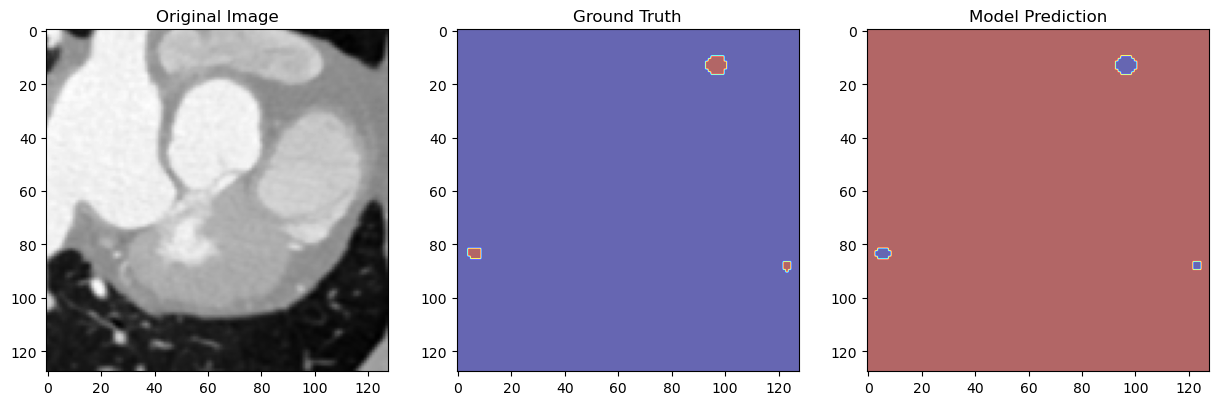

In [29]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random sample from test_loader
random_index = random.randint(0, len(test_ds) - 1)  # Get a random index

# Load the sample
sample = test_ds[random_index]

# Extract image, ground truth, and model prediction
image = sample["image"].unsqueeze(0).to(device)  # Add batch dimension
label = sample["label"].cpu().numpy()[0, :, :, 64]  # Extract slice in z-direction

# Get model prediction
with torch.no_grad():
    pred = model(image)
    pred = post_pred(pred[0].cpu()).numpy()[0, :, :, 64]  # Extract slice

# Convert image for visualization
image = image.cpu().numpy()[0, 0, :, :, 100] 

# Plot the image, ground truth, and prediction
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(label, cmap="jet", alpha=0.6)

plt.subplot(1, 3, 3)
plt.title("Model Prediction")
plt.imshow(pred, cmap="jet", alpha=0.6)

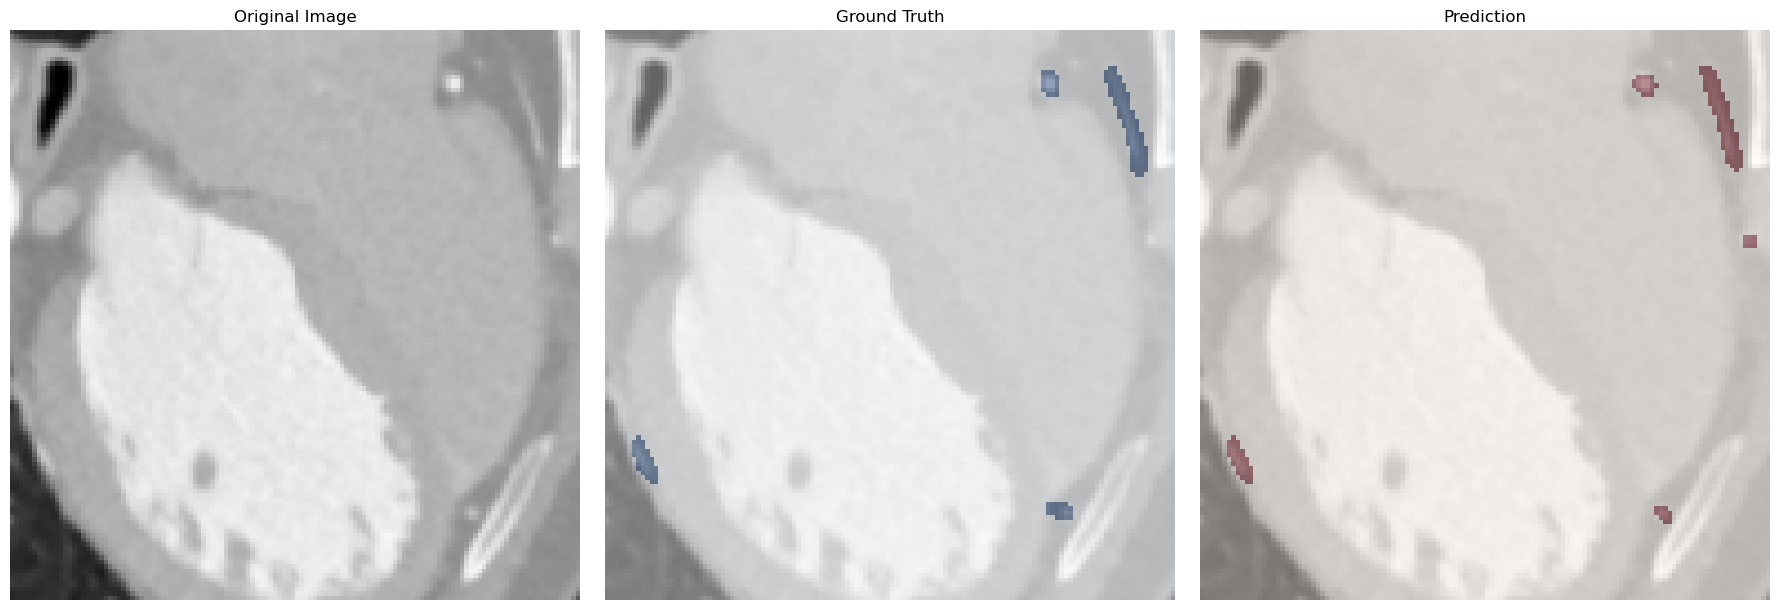

In [32]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random sample from test_ds
random_index = random.randint(0, len(test_ds) - 1)
sample = test_ds[random_index]

# Extract image and label
image_tensor = sample["image"].unsqueeze(0).to(device)  # [1, C, H, W, D]
label = sample["label"].cpu().numpy()                   # [C, H, W, D]

# Choose central slice in z-direction
z_index = image_tensor.shape[-1] // 2

# Run inference
model.eval()
with torch.no_grad():
    prediction = model(image_tensor)
    prediction = post_pred(prediction[0].cpu())  # Apply argmax+onehot
    prediction = prediction.numpy()

# Extract relevant slices
image_slice = image_tensor.cpu().numpy()[0, 0, :, :, z_index]
label_slice = label[0, :, :, z_index]
pred_slice = prediction[1, :, :, z_index]  # Class 1 (foreground) only

# Plot with overlays
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_slice, cmap="gray")
plt.axis("off")

# Image + Ground Truth Overlay
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(image_slice, cmap="gray")
plt.imshow(label_slice, cmap="Blues", alpha=0.4)  # GT mask in blue
plt.axis("off")

# Image + Model Prediction Overlay
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(image_slice, cmap="gray")
plt.imshow(pred_slice, cmap="Reds", alpha=0.4)    # Prediction mask in red
plt.axis("off")

plt.tight_layout()
plt.show()

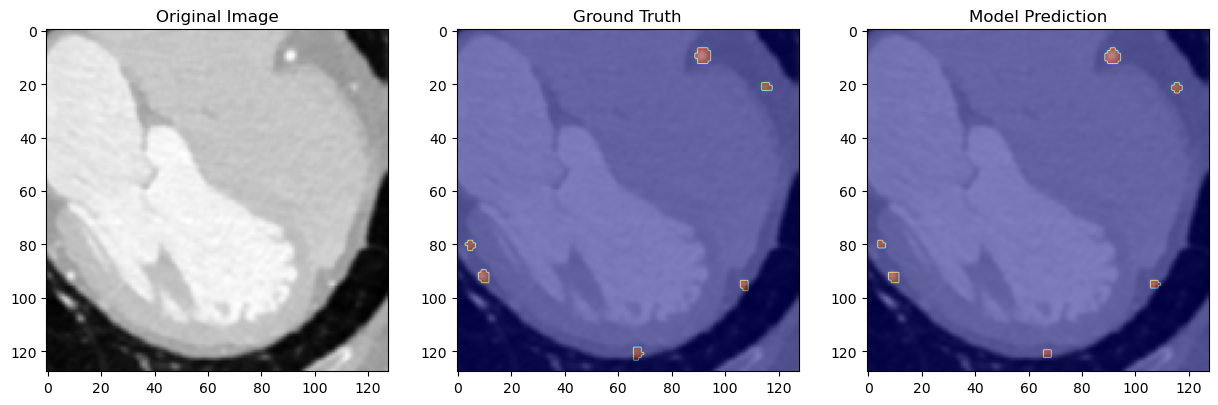

In [34]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random sample from test_loader
random_index = random.randint(0, len(test_ds) - 1)  # Get a random index

# Load the sample
sample = test_ds[random_index]

# Extract image, ground truth, and model prediction
image = sample["image"].unsqueeze(0).to(device)  # Add batch dimension
label = sample["label"].cpu().numpy()[0, :, :, 64]  # Extract slice in z-direction

# Get model prediction
with torch.no_grad():
    pred = model(image)
    pred = post_pred(pred[0].cpu()).numpy()[0, :, :, 64]  # Extract slice

# Convert image for visualization
image = image.cpu().numpy()[0, 0, :, :, 64]  # Extract grayscale image slice

# Binarize the Ground Truth and Prediction
label = (label > 0.5).astype(np.uint8)  # Convert to 0 and 1
pred = (pred > 0.5).astype(np.uint8)    # Convert to 0 and 1

# Fix Reversed Labels
# If segmentation appears inverted, flip values (0 ↔ 1)
if np.mean(pred) > 0.5:  # If prediction is mostly 1s (inverted), flip it
    pred = 1 - pred

# Plot the image, ground truth, and prediction
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(image, cmap="gray")  # Show grayscale image
plt.imshow(label, cmap="jet", alpha=0.5)  # Overlay label

plt.subplot(1, 3, 3)
plt.title("Model Prediction")
plt.imshow(image, cmap="gray")  # Show grayscale image
plt.imshow(pred, cmap="jet", alpha=0.5)  # Overlay prediction

plt.show()